# IAM - Power System Model soft-link tool

Copyright (c) 2022 Maarten Brinkerink

This work is released under the MIT License. See the LICENSE file for more information. 

Please refer to/cite https://doi.org/10.1016/j.envsoft.2022.105336 while using this methodological soft-link framework and refer to the README file for other sources to be cited as used for the overall workflow in this script. 
_______________________________________________________________________________________________________________________________

This tool applies spatial downscaling of IAM output scenario data (electricity demand and powerplant capacities) developed with direct connections to IAM databases or IAM excel output files and the PLEXOS-World database on Harvard Dataverse. It furthermore extracts other required variables for power system modelling if available. The script can be used to standardize the overall workflow in the methodological soft-link framework as introduced in the paper 'Assessing global climate change mitigation scenarios from a power system perspective using a novel multi-model framework'. Linking the global IAM scenarios to PLEXOS-World (or any global power system model) has multiple purposes;

I) To improve the spatial resolution of the IAM scenario to be able to assess its power system implications with higher locational detail.

II) To assess the IAM scenario from a power system perspective with higher temporal and technical resolution.

III) To use the power system model simulation output as a benchmark for the power system representation in the IAM.

IV) To use the power system model simulation output and general modelling observations to update or improve the stylized power system representation in the IAM.

The output of this script consists of multiple pandas DataFrames/CSV files with data that can be used as input for the power system model. Additional data conversion outside this script might be necessary depending on power system model specific data templates.

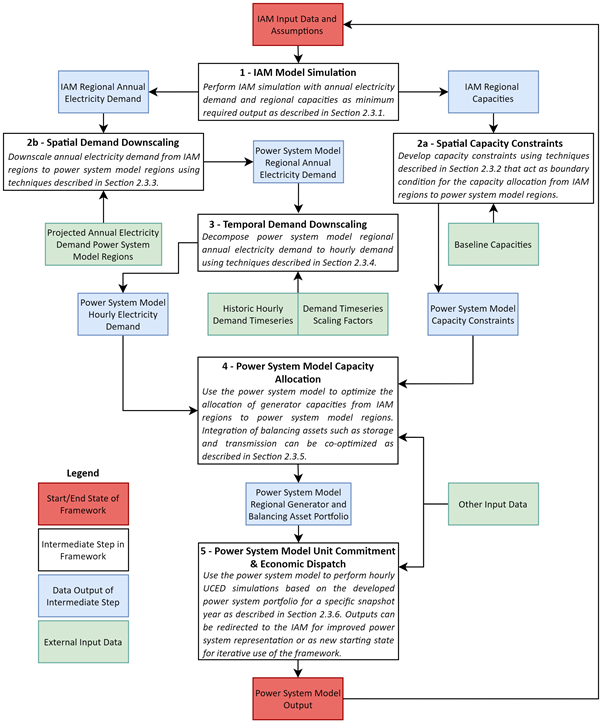 Overview of the soft-link framework. Steps 1-3 in the framework can be performed with this script. The graph is extracted from Brinkerink et al., 2022 (https://doi.org/10.1016/j.envsoft.2022.105336)

## Import modules

In [1]:
import pandas as pd
import numpy as np
import xlsxwriter
import pyam
import os
import requests
import world_bank_data as wb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

## Define IAM model characteristics
Determine for which models, scenarios, SSP pathway and snapshot year the scenario file needs to be created. <b><span style='color:red'>This is the only section WITHIN the script where manual entries are required. </span></b> Note that demand projections in this script are SSP pathway specific, hence if different SSP's are to be used the script needs to be rerun multiple times with different input parameters (models, scenarios and pathway). The same counts for other parameters such as the respective spatial mapping. For general pathway data it is advisable to use 'SSP2' as  'middle of the road' projection if the to be assessed scenarios are not directly linked to the SSP's.

<b><span style='color:red'>The 'Custom Input' section - few cells down - defines the input data OUTSIDE the script where manual entries are required. Definition of mapping dictionaries (e.g. for defining spatial and technological representation) has to be pre-specified in the 'memberships' input excel file. </span></b>

In [2]:
models = ['MESSAGE-GLOBIOM 1.0' , 'AIM/CGE 2.0' , 'IMAGE 3.0.1'] #Define the IAM models to be assessed

scenarios = ['ADVANCE_2020_1.5C-2100'] #Define the scenarios to be assessed

source = 'database' #Define whether scenario data is read from a 'database', 'xlsx' or 'csv' file.

if source != 'database': #Define directory for IAM output data source file in case 'database' is not used. 
    IAM_output_directory = r''
    IAMC_format = 'wide' #Define whether 'wide' or 'long' format is used in source file in case 'database' is not used.

#Define where the output files of the script need to be saved.     
script_output_directory = r''

assert os.path.exists(script_output_directory), f'Folder {script_output_directory} does not exist! Change the script_output_directory variable to an available folder!'

pathway = 'SSP2' #For general country-level SSP data such as GDP, population and urbanization data. 
POP_countries_source = 'IIASA-WiC POP' #Options are 'IIASA-WiC POP' and 'NCAR'
GDPppp_countries_source = 'OECD Env-Growth' #Options are 'IIASA GDP' and 'OECD Env-Growth'. 'OECD Env-Growth' has more entries.

spatial_mapping = 'R5' #Define the required spatial mapping. Custom mapping can be added to the 'memberships' input 
#excel file as a seperate sheet titled with the variable name followed by _spatial_mapping - E.g. R5_spatial_mapping. 

technology_mapping = 'ADVANCE' #Define the required technological mapping used to convert naming conventions or aggregate 
#technolgies from the IAM output to required power system model input. Custom mapping can be added to the 'memberships' input 
#excel file as a seperate sheet titled with the variable name followed by _technology_mapping - E.g. ADVANCE_technology_mapping. 

snapshot_year  = 2050 #Determine which year of the IAM scenario output the power system model is supposed to assess.

urbanization = 'Yes' #Include urbanization as part of the linear regression? 'Yes' or 'No'

electricity_demand_type = 'Final Energy|Electricity' #Determine which IAM variable should be used for the electricity 
#demand downscaling. For a modelling exercise where all technologies and demands are incorporated in the power system model
#which require electricity (being at the final or secondary level) the 'Final Energy|Electricity' variable can be used. 
#In this case the script will calculate the electricity demand that needs to be met in the power system model as 
#'Final Energy|Electricity' + Domestic Transmission & Distribution losses. In a situation where the power system model is solely
#used to simulate the power sector without interactions with other sectors (e.g. CHP or Electricity produced Hydrogen for other 
#sectors) or where certain technologies that require electricity at the secondary level are not included it can be more accurate
#to use the 'Secondary Energy|Electricity' variable as starting point for the demand downscaling. If used, 
#'Secondary Energy|Electricity' - Domestic Transmission & Distribution losses will be used as the electricity demand that needs 
#to be met in the power system model. Both options have its clear limitations and a case by case approach should be used to 
#determine the best fit.

peak_load_max = 1 #Change value if relative peak demand needs to change relatively to 2015 uniformally for all global nodes.

hourly_demand_generator = 'No' #'Yes' in case hourly demand profiles need to be developed within the script. Only possible
#when peak_load_max == 1 since within this script only linear scaling of timeseries is feasible. Non-linear scaling requires
#optimization which is not supported.

## Loads IAM model and scenario specific data
Automatically extracts the relevant scenario data from either the IAMC 1.5°C Scenario Explorer or from a seperate excel or csv file specific for the above identified ensemble. 

In [3]:
#Creates list of entries by means of entered model and scenario combinations. 
entries_base = [ (a + '|' + b)
                for a in models
                for b in scenarios ]
entries = []

#Creates empty dataframe dictionaries to be filled. 
import_scenario = {}
import_year_scenario = {}
import_year_scenario_generator_capacity = {}
import_year_scenario_generator_efficiency = {}

#Pulls scenario data from the IAMC 1.5°C scenario Explorer.
if source == 'database':
    conn = pyam.iiasa.Connection('IXSE_SR15')

#Pulls scenario data from csv file.
elif source == 'csv':
    conn = pd.read_csv(IAM_output_directory , encoding = 'unicode_escape')

#Pulls scenario data from xlsx file.
else:
    conn = pd.read_excel(IAM_output_directory , encoding = 'unicode_escape')

for a in entries_base:
    
    model = a.split("|",1)[0]
    scenario = a.split("|",1)[1]
    
    #converts 'wide' to 'long' IAMC data format if required. 
    if source != 'database' and IAMC_format == 'wide':
        conn.columns = [str(x).lower() for x in conn.columns]
        conn['year'] , conn['value'] = snapshot_year , conn[str(snapshot_year)]
      
    #Creates model and scenario specific dataframe.    
    if source == 'database':
        import_scenario[a] = (conn.query(model = model , scenario = scenario)).as_pandas()
        #query function in pyam returns full dataframe if filter entry combination is non existing
        import_scenario[a] = (import_scenario[a].loc[(import_scenario[a]['model'] == model) & 
                                                     (import_scenario[a]['scenario'] == scenario)])

    else:
        import_scenario[a] = (conn.loc[(conn['model'] == model) & (conn['scenario'] == scenario)])
        
    #Checks if scenario model combination exists if not removes it before filtering
    if model not in import_scenario[a]['model'].values and scenario not in import_scenario[a]['scenario'].values:
        print(f'{a} model|scenario combination does not exist in used database!')
    
    else:
        entries.append(a)
        
        import_scenario[a] = import_scenario[a][['model' , 'scenario' , 'variable' , 'unit' , 'region' , 'year' , 'value']]

        #Creates model and scenario specific dataframe for the specific snapshot year.
        import_year_scenario[a] = import_scenario[a].loc[import_scenario[a]['year'] == snapshot_year]

        #Creates model and scenario specific dataframe for Capacity|Electricity data for the specific snapshot year.
        import_year_scenario_generator_capacity[a] = import_year_scenario[a].loc[import_year_scenario[a]['variable']
                                                                                 .str.startswith('Capacity|Electricity|')]

        #Creates model and scenario specific dataframe for Efficiency|Electricity data for the specific snapshot year.
        import_year_scenario_generator_efficiency[a] = import_year_scenario[a][import_year_scenario[a]['variable']
                                                                               .str.contains('Efficiency\|Electricity')]

#Will result in index error if no valid model|scenario combinations are given.
import_year_scenario_generator_capacity[entries[-1]].head(1)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.iiasa - INFO: You are connected to the IXSE_SR15 scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/iamc-1.5c-explorer/#/about
pyam.iiasa - INFO: You are connected as an anonymous user


,model,scenario,variable,unit,region,year,value
9,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,Capacity|Electricity|Biomass,GW,R5ASIA,2050,632.314181


## Custom Input

The workflow of the soft-linking exercise requires input data from external sources. Some of this can be automated (e.g. connections to the World Bank API and to the Harvard Dataverse for PLEXOS-World 2015 data) yet additional input is required that needs to be manually specified in input excel files. This is relevant for the following;

<B>I)</B> 'memberships.xlsx' 'spatial_mapping' sheet needs to be defined for the required spatial mapping. 'country' column requires ISO-3 country codes as input, 'node' column requires PLEXOS-World 2015 naming conventions as input to link to baseline electricity demand and power plant capacity data. The 'region' column requires the required region mapping based on the specific IAM scenario ensemble. Note that by default data for all regions that are added in the 'region' column are processed in this script. If the focus is on some but not all regions from the global model the spatial mapping should ONLY be added for those regions. Naming conventions for PLEXOS-World 2015 can be found in the supplementary material file for https://doi.org/10.1016/j.esr.2020.100592 located at https://doi.org/10.7910/DVN/CBYXBY.

<B>II)</B> 'memberships.xlsx' 'PLEXOS_World_2015_fuel_mapping' sheet needs to be defined to match technologies from the PLEXOS-World 2015 dataset (based on which baseline nodal powerplant capacities are determined) with the required power system model input categories.

<B>III)</B> 'memberships.xlsx' 'technology_mapping' sheet needs to be defined to match IAM technology categories with power system model input categories. For example, aggregation of technologies can be relevant if the number of technologies need to be restricted in the power system model for computational reasoning (e.g. in the case of MESSAGEix-GLOBIOM Gas|w/o CCS|2 and Gas|w/o CCS|3 can be aggregated into Gas|OCGT|w/o CCS). Capacities in the script will be aggregated and the technology efficiency will be determined based on a capacity weighted average. The script checks whether all technologies from the IAM output are in the 'IAM' column of the sheet, if not it returns an error identifying the missing technology.

The 'PSM_capacity' column should include the power system model input categories based on which IAM technology capacities are to be allocated. If a technology is to be excluded (e.g. to exclude the 'Coal' technology if 'Coal|w/ CCS' and 'Coal|w/o CCS' are specified to prevent double counting) the 'PSM_capacity' column requires an 'Exclude' entry. Conversion of technology names (e.g. from Wind to Wind|Onshore) can be relevant if the power system model requires technology specific inputs but the supplied IAM output does not provide this. If a technology name is to remain the same the 'PSM_capacity' column requires the same entry (e.g. enter 'Geothermal' in both columns). The 'PSM_efficiency' column requires power system model input categories as entries to which the specific IAM technology contributes in calculation of capacity weighted efficiencies and heat rates.

<B>IV)</B> 'POP_GDP_URB_missing.xlsx' is used to add custom country-level projections for population, gdp and urbanization in case SSP data is not available. This is only relevant for smaller countries not covered by the SSP projections. The script checks whether country-level projections are available based on either SSP or custom data and if not it returns an error identifying the countries for which data is missing.

<B>V)</B> 'T&D losses.xlsx' includes country-level T&D losses per 5-year interval based on Sadovskaia et al., 2019; https://doi.org/10.1016/j.ijepes.2018.11.012. Yet data does not exist for most smaller countries/islands and hence has to be manually added at the bottom of the 'T&D losses.xlsx' file. As a best estimate, data for these countries can be based on neighbouring countries of similar size and development status. The script checks whether country-level projections are available for all to be modelled countries and if not it returns an error identifying the countries for which data is missing.

### Input dictionaries

Imports the required naming conventions and memberships to link and disaggregate IAM scenario data. Furthermore checks whether the dictionary entries are in line with the specific IAM scenario variables. If not it returns an error and identifies the issue.

In [4]:
import_spatial_mapping = pd.read_excel('Input Data\\memberships.xlsx' , 
                                       sheet_name = f'{spatial_mapping}_spatial_mapping')

import_memberships_technologies = pd.read_excel('Input Data\\memberships.xlsx', 
                                                sheet_name = f'{technology_mapping}_technology_mapping')

import_memberships_fuels_PW2015 = pd.read_excel('Input Data\\memberships.xlsx' , 
                                                sheet_name = f'{technology_mapping}_PW2015_fuel_mapping')

import_spatial_mapping.head(1)

,country,node,region
0,AFG,AS-AFG,R5ASIA


In [5]:
#Sets initial spatial mapping dictionaries ungrouped.
dict_countries = dict(zip(import_spatial_mapping.country, import_spatial_mapping.region))
dict_nodes = dict(zip(import_spatial_mapping.node, import_spatial_mapping.region))
dict_technologies_capacity = dict(zip(import_memberships_technologies.IAM, import_memberships_technologies.PSM_capacity))
dict_technologies_efficiency = dict(zip(import_memberships_technologies.IAM, import_memberships_technologies.PSM_efficiency))

mapping_countries = {}
mapping_nodes = {}

#Groups all keys per value.
for key, value in sorted(dict_countries.items()):
    mapping_countries.setdefault(value, []).append(key)
    
for key, value in sorted(dict_nodes.items()):
    mapping_nodes.setdefault(value, []).append(key)

#Sets dictionary for Capacity|Electricity variables
dict_technologies_capacity_variable = {'Capacity|Electricity|' + a: 
                                       'Capacity|Electricity|' + b for a, b in dict_technologies_capacity.items()}

dict_technologies_efficiency_variable = {'Efficiency|Electricity|' + a: 
                                         'Efficiency|Electricity|' + b for a, b in dict_technologies_efficiency.items()}

#Checks whether spatial and technology mapping in 'memberships.xlsx'are in line with IAM scenario output. Returns errors
#if values are missing or incorrect. 
dic_check_capacity = pd.DataFrame()

for c in entries:

    dic_check_capacity = pd.concat([dic_check_capacity, import_year_scenario_generator_capacity[c][['variable' , 'region']]])
    dic_check_capacity = dic_check_capacity[~dic_check_capacity['region'].str.contains('World')].drop_duplicates()
    
#Checks whether all IAM scenario Capacity|Electricity variables are defined in 'memberships.xlsx' technology_mapping sheet.
for d in dic_check_capacity['variable'].unique():
    
    e = '|'.join(d.split("|", 2)[2:])
    assert d in dict_technologies_capacity_variable.keys(), f'{e} not defined in memberships.xlsx sheet {technology_mapping}_technology_mapping IAM column.'
    
#Checks whether all IAM scenario regions are defined in 'memberships.xlsx' spatial_mapping sheet and gives warning if not.
#Not all regions are necessary to be defined in case a regional analysis is to be applied rather than all regions for the
#specific scenario.

for f in dic_check_capacity['region'].unique():
    
    if f not in dict_nodes.values():
        print(f'Warning! {f} not defined in memberships.xlsx sheet {spatial_mapping}_spatial_mapping.')    
    
#Checks whether naming conventions for technologies as defined in memberships.xlsx sheet PW2015_fuel_mapping PSM column 
#are in line with memberships.xlsx sheet technology_mapping sheet PSM_capacity column. This determines whether the input 
#baseline powerplant capacities from PLEXOS-World 2015 are allocated to the correct technology for the power system model input.
#In some cases (e.g. Wind|Offshore) where technologies are not part of the model ensemble a mismatch is possible.
for g in import_memberships_fuels_PW2015.PSM.unique():
    
    if g not in dict_technologies_capacity.values():
        print(f'Warning! {g} defined in memberships.xlsx sheet {technology_mapping}_PW2015_fuel_mapping PSM column but not in {technology_mapping}_technology_mapping PSM column.')

### Loads SSP data

Loads input excel files that include SSP projections for Population (POP), Gross Domesitic Product Purching Power Parity per person (GDPppp) and urbanization (URB) that can be found on the 'SSP Database (Shared Socioeconomic pathways) - Version 2.0' https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=30. For smaller countries that are not included in the SSP projections, custom data has to be included in the respective input xlsx files.

In [6]:
#Datafiles with country-level SSP projections as retrieved from the SSP Database.
import_POP_SSP = pd.read_excel('Input Data\\iamc_db_POP_countries.xlsx')
import_GDPppp_SSP = pd.read_excel('Input Data\\iamc_db_GDPppp_countries.xlsx')
import_URB_SSP = pd.read_excel('Input Data\\iamc_db_URB_countries.xlsx')

#Datafiles with custom country-level projections.
import_POP_missing = pd.read_excel('Input Data\\POP_GDP_URB_missing.xlsx' , sheet_name = 'POP')
import_POP_missing = import_POP_missing.loc[(import_POP_missing['SSP'] == pathway)]
import_GDP_missing = pd.read_excel('Input Data\\POP_GDP_URB_missing.xlsx' , sheet_name = 'GDP|PPP')
import_GDP_missing = import_GDP_missing.loc[(import_GDP_missing['SSP'] == pathway)]
import_URB_missing = pd.read_excel('Input Data\\POP_GDP_URB_missing.xlsx' , sheet_name = 'URB')
import_URB_missing = import_URB_missing.loc[(import_URB_missing['SSP'] == pathway)]

import_GDPppp_SSP.head(1)

,model,scenario,region,variable,unit,2010,2015,2020,2025,2030,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,notes
0,OECD Env-Growth,SSP1,ABW,GDP|PPP,billion US$2005/yr,0.151,0.205,0.266,0.357,0.492,...,2.586,3.165,3.797,4.47,5.171,5.842,6.469,7.034,7.505,NaN


### Loads historic country-level data (GDPppp, & urbanization) from the World Bank
Based on the World Bank's World Development Indicators (WDI) retrieved through the World Bank python API.

In [7]:
#Extracts historical GDP|PPP per capita from the World Bank API
import_country_GDP_WB = pd.DataFrame(wb.get_series('NY.GDP.PCAP.PP.KD', date = '1985:2020' , id_or_value = 'id')
                                    ).reset_index().rename(columns = {'NY.GDP.PCAP.PP.KD' : 'WB_GDPppp' , 'Country' : 
                                                                      'country' , 'Year' : 'year'}).set_index('country')

#Extracts Urban population (% of total population) from the World Bank API.
import_country_URB_WB = pd.DataFrame(wb.get_series('SP.URB.TOTL.IN.ZS', date = '1985:2020' , id_or_value = 'id')
                                    ).reset_index().rename(columns = {'SP.URB.TOTL.IN.ZS' : 'WB_URB' , 'Country' : 
                                                                      'country' , 'Year' : 'year'}).set_index('country')

import_country_URB_WB.tail(1)

,Series,year,WB_URB
country,,,
ZWE,SP.URB.TOTL.IN.ZS,2020,32.242


### Loads historic country-level per capita electricity consumption data from Our World In Data
Based on data from BP and Ember. Retrieved through https://ourworldindata.org/energy-production-consumption

In [8]:
import_country_CON_OWID = pd.read_csv('Input Data\\owid_pcconsumption.csv'
                                   ).iloc[: , -3:].rename(columns = {'Per capita electricity (kWh)' : 'OWID_CON' , 'Code' : 
                                                                     'country' , 'Year' : 'year'}).set_index('country')

import_country_CON_OWID['year'] = import_country_CON_OWID['year'].astype('str')

import_country_CON_OWID.tail(1)

,year,OWID_CON
country,,
ZWE,2019,617.692045


### Loads model data from PLEXOS-World 2015 from Harvard Dataverse
Automatically extracts the relevant data of the PLEXOS-World 2015 model from the dedicated Harvard Dataverse. More specifically, nodal level capacity- and demand data is extracted that is used as baseline for disaggregation of the regional IAM scenario data. The PLEXOS-World 2015 model includes over 30,000 powerplants and has a spatial representation of more than 250 nodes covering the globe.

#### Retrieves PLEXOS-World 2015 model data
Used to calculate 2015 baseline generator capacities per node and technology.

In [9]:
#Checks whether the PLEXOS-World 2015 raw model data file needs to be retrieved from the PLEXOS World Harvard Dataverse or 
#whether the file already exists in the local folder.
try:
    import_PLEXOS_2015_properties = pd.read_excel('Input Data\\PLEXOS World 2015 Gold V1.1.xlsx' , sheet_name = 'Properties' , 
                                                  usecols = ['child_class' , 'child_object' , 'property' , 'value'])

    import_PLEXOS_2015_memberships = pd.read_excel('Input Data\\PLEXOS World 2015 Gold V1.1.xlsx' , sheet_name = 'Memberships', 
                                              usecols = ['parent_class' , 'child_class' , 'parent_object' , 'child_object'])
    
except IOError:
    
    url = 'https://dataverse.harvard.edu/api/access/datafile/4008393?format=original&gbrecs=true'
    r = requests.get(url)
    with open('Input Data\\PLEXOS World 2015 Gold V1.1.xlsx', 'wb') as outfile:
        outfile.write(r.content)
    
    import_PLEXOS_2015_properties = pd.read_excel('Input Data\\PLEXOS World 2015 Gold V1.1.xlsx' , sheet_name = 'Properties' , 
                                                  usecols = ['child_class' , 'child_object' , 'property' , 'value'])

    import_PLEXOS_2015_memberships = pd.read_excel('Input Data\\PLEXOS World 2015 Gold V1.1.xlsx' , sheet_name = 'Memberships', 
                                              usecols = ['parent_class' , 'child_class' , 'parent_object' , 'child_object'])

#### Retrieves PLEXOS-World 2015 hourly demand data incl. T&D losses for all nodes
Used to be able to disaggregate regional electricity demand to nodal level as well as calculate relative peak demand and optionally develop hourly demand profiles for future years based on linear scaling.

In [10]:
#Checks whether the All demand UTC 2015.csv datafile needs to be retrieved from the PLEXOS-World Harvard Dataverse or whether
#the file already exists in the local folder.
try:
    
    import_hourly_demand_2015 = pd.read_csv('Input Data\\All Demand UTC 2015.csv')
    
except IOError:
    
    url = 'https://dataverse.harvard.edu/api/access/datafile/3985039?format=original&gbrecs=true'
    r = requests.get(url)
    with open('Input Data\\All Demand UTC 2015.csv', 'wb') as outfile:
        outfile.write(r.content)
    
    import_hourly_demand_2015 = pd.read_csv('Input Data\\All Demand UTC 2015.csv')
    
import_hourly_demand_2015.head(2)

,Datetime,EU-AUT,EU-BEL,EU-BGR,EU-BIH,EU-CHE,EU-CYP,EU-CZE,EU-DEU,EU-DNK,...,OC-FJI,OC-PNG,SA-BOL,SA-COL,SA-ECU,SA-GUF,SA-GUY,SA-PRY,SA-SUR,SA-VEN
0,01/01/2015,7847,10281,5267,1749,8205,437,6931,54544,3382,...,126,550,1300,9541,3911,39,136,2626,270,16344
1,01/01/2015 01:00,7480,9785,5032,1658,8214,413,6816,52795,3301,...,125,544,1197,9215,3973,38,121,2514,266,14925


### Loads projected electricity transmission & distribution losses

Country-level T&D losses per 5-year interval are added to the scenario specific country-level Final Energy|Electricity based on Sadovskaia et al., 2019; https://doi.org/10.1016/j.ijepes.2018.11.012. T&D within nodes is generally not modelled in continental power system models for computational reasoning.

In [11]:
import_losses = pd.read_excel('Input Data\\T&D losses.xlsx')

#Checks whether T&D is available for all included countries. An assertion error pops up in case data is missing. 
#In this case either data needs to be added to 'T&D losses.xlsx' or the country needs to be removed from the 
#to be included countries. This is only relevant for smaller countries and islands that haven't been included to-date.
losses_missing = import_spatial_mapping.country[(~import_spatial_mapping.country.isin(import_losses.country))]

assert losses_missing.empty , print(losses_missing)

## Calculates nodal level electricity demand
In the following section the nodal level final electricity demand (including transmission and distribution (T&D) losses) and hourly peak demand will be determined for the IAM scenario and where needed hourly scenario specific demand profiles for all nodes can be developed. 

<B>The following steps are taken;</B>

<B>I)</B> Socioeconomic pathway (SSP) specific country-level population (POP), urbanization (URB) and Gross Domestic Product Purchasing Power Parity (GDP|PPP) projections are extracted from the SSP database and formatted to be used to project country-level electricity demand. Country-level pathway data is available for the majority of countries globally, yet not for all (e.g. GDP|PPP for AS-PRK). Hence for these countries, if to be included in the modelling, custom data needs to be provided in the 'POP_GDP_URB_missing.xlsx' file. Both data sources are appended and formatted to be used as weight dataframe for the PYAM downscale_region function.

SSP database can be found here;  'SSP Database (Shared Socioeconomic pathways) - Version 2.0' https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=30. Details on PYAM's downscale_region function can be found here; https://pyam-iamc.readthedocs.io/en/stable/tutorials/aggregating_downscaling_consistency.html.

<B>II)</B> Historic regression relationships have been inferred per region (e.g. per R5 region) based on datasets from the World Bank's World Development Indicators (WDI) and Our World In Data (OWID). Country-level values for the period 1985-2020 are used as entries with electricity consumption as dependent variable (from OWID) and GDP|PPP and (optionally) URB as independent variables (from WB WDI). More information on the WDI can be found here; http://datatopics.worldbank.org/world-development-indicators/. More information on the World Bank's WDI python package can be found here; https://pypi.org/project/world-bank-data/. More information on OWID can be found here; https://ourworldindata.org/. More information on the underlying datasets as used in the OWID per capacity electricity consumption dataset can be found here; https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html and here; https://ember-climate.org/data/. 

<B>III)</B> The country-level POP and GDP|PPP (and optionally URB) (step I) are entered into the inferred relationships (step II) to project pathway specific country-level electricity demand. 

<B>IV)</B> Weight dataframes get created based on the projected country-level demand values (step III).

<B>V)</B> Scenario specific regional electricity demand values (final or secondary) and transmission loss values (if applicable) are extracted from the IAM database. If transmission loss values based on the 'Secondary Energy|Electricity|Transmission Losses' variable are available they will either be added to the final demand or substracted from secondary demand depending on which demand type is chosen.

<B>VI)</B> The weight dataframes (step IV) are used to downscale the scenario specific regional electricity demand values (final or secondary) (step V) to country-level.

<B>VII)</B> If transmission loss values based on the 'Secondary Energy|Electricity|Transmission Losses' variable are NOT available for the specific scenario ensemble, custom country level T&D losses are retrieved and either added to the final demand or substracted from secondary demand depending on which demand type is chosen. Country-level T&D losses per 5-year interval are retreived from Sadovskaia et al., 2019; https://doi.org/10.1016/j.ijepes.2018.11.012.

<B>VIII)</B> Specific for sub-country nodes (relevant for Australia, Brazil, Canada, China, India, Japan, Russia and the united States in the PLEXOS-World model), the 2015 relative share of electricity demand per sub-country node (based on PLEXOS-World data) is used to decompose the calculated country-level electricity demand (step VII) following the assumption that relative demand shares remain equal.

<B>IX)</B> Constrains the forecasted electricity demand (step VIII) to 2015 baseline values in case the projected value for the scenario year is <= 0. In case of linear regression, small countries with signficantly lower projected independent variables (GDP|PPP, urbanization) compared to the regional average can lead to very low and often negative projected demand values (e.g. EU-KOS). Albeit a rough method, this is only relevant for small countries.

<B>X)</B> In case negative values occured and demand values had to be scaled up (step IX), demand values of other areas belonging to the IAM region are comparitively scaled down as such that the sum of individual demands of all areas equals the reported demand from the IAM region.

<B>XI)</B>  2015 hourly peak demand per node relative to the total demand (based on PLEXOS-World data) is used to calculate scenario and year specific hourly peak demand following the assumption that the relative peak to total demand ratio remains equal compared to 2015. Countries that weren't included in the 2015 dataset get assigned a dataset average peak to total demand ratio. The assumption of equal relative peak load compared to 2015 can be manually adjusted at the beginning of this script if required, yet note that if hourly demand profiles (step XII) are to be created within the script this can only occur in a linear fashion. If profiles are to be scaled in a non-linear fashion this becomes an optimization problem and needs to occur outside this script (e.g. PLEXOS has a built-in profile builder tool that is capable of doing this). The calculated electricity demand values (step IX), and adjusted peak min/max demand values can then be used as boundary constraints for the scaling of the baseline hourly demand profiles (e.g. from the PLEXOS-World dataset) outside this script.

<B>XII)</B> As an optional cell - to be activated by setting the <i>hourly_demand_generator</i> variable to 'Yes' and the <i>peak_load_max</i> variable to 1 (linear) at the beginning of this script - scenario, year and node specific hourly demand profiles can be developed based on linear scaling. Note that this follows the setup of the 2015 calendar year, hence different order of weekdays/weekends or extra days following possible leap years are not considered.

### I) Extracts pathway and year specific country-level POP data and creates weights dataframe for downscaling of the regional data

In [12]:
#Copies relevant columns from the the 'iamc_db_POP_countries' datafile and filters relevant rows. In millions
country_POP_raw = import_POP_SSP[['model' , 'scenario' , 'region' , snapshot_year]].copy()

#Filters relevant data based on earlier given entries (SSP pathway and source for POP)
country_POP_raw = country_POP_raw.loc[(country_POP_raw['model'] == POP_countries_source) & 
                                      (country_POP_raw['scenario'] == pathway)].rename(columns = {'region' : 'country'})

country_POP_raw = pd.merge(import_spatial_mapping.country , country_POP_raw[['country' , snapshot_year]] , 
                           on = 'country' , how = 'outer').dropna()

#Checks whether pathway data is available for all included countries.
country_POP_raw_missing = import_spatial_mapping.country[(~import_spatial_mapping.country.isin(country_POP_raw.country))]

#In case pathway data is not available for all countries it checks wheter custom data is provided in 'POP_GDP_URB_missing.xlsx' 
#If not, an assertion error pops up indicating for which country data is missing. In this case either data needs to be added or 
#the country needs to be removed from the to be included countries.
country_POP_raw_missing = pd.merge(country_POP_raw_missing , import_POP_missing[['country' , snapshot_year]] , 
                           on = 'country' , how = 'left')

assert country_POP_raw_missing.notnull().values.all() , print(country_POP_raw_missing)

country_POP_raw = pd.concat([country_POP_raw, country_POP_raw_missing]).drop_duplicates().set_index('country')

country_POP_raw.head(1)

,2050
country,
AFG,75.161958


### I) Extracts pathway and year specific country-level GDPppp data and creates weighting dataframe for downscaling of the regional data

In [13]:
#Copies relevant columns from the the 'iamc_db_GDPppp_countries' datafile and filters relevant rows. In millions
country_GDP_raw = import_GDPppp_SSP[['model' , 'scenario' , 'region' , snapshot_year]].copy()

#Filters relevant data based on earlier given entries (SSP pathway and source for GDPppp)
country_GDP_raw = country_GDP_raw.loc[(country_GDP_raw['model'] == GDPppp_countries_source) & 
                                                           (country_GDP_raw['scenario'] == pathway)
                                     ].rename(columns = {'region' : 'country'})

country_GDP_raw = pd.merge(import_spatial_mapping.country , country_GDP_raw[['country' , snapshot_year]] , 
                           on = 'country' , how = 'outer').dropna()

#Checks whether pathway data is available for all included countries.
country_GDP_raw_missing = import_spatial_mapping.country[(~import_spatial_mapping.country.isin(country_GDP_raw.country))]

#In case pathway data is not available for all countries it checks wheter custom data is provided in 'POP_GDP_URB_missing.xlsx' 
#If not, an assertion error pops up indicating for which country data is missing. In this case either data needs to be added or 
#the country needs to be removed from the to be included countries.
country_GDP_raw_missing = pd.merge(country_GDP_raw_missing , import_GDP_missing[['country' , snapshot_year]] , 
                           on = 'country' , how = 'left')

assert country_GDP_raw_missing.notnull().values.all() , print(country_GDP_raw_missing)

country_GDP_raw = pd.concat([country_GDP_raw, country_GDP_raw_missing]).drop_duplicates().set_index('country')

country_GDP_raw.head(1)

,2050
country,
AFG,314.371


### I) Extracts pathway and year specific country-level urbanization data and creates weights dataframe for downscaling of the regional data

In [14]:
#Copies relevant columns from the the 'iamc_db_URB_countries' datafile and filters relevant rows. In % of total population
country_URB_raw = import_URB_SSP[['model' , 'scenario' , 'region' , snapshot_year]].copy()

#Filters relevant data based on earlier given entries (SSP pathway and source for URB)
country_URB_raw = country_URB_raw.loc[(country_URB_raw['model'] == 'NCAR') & 
                                                           (country_URB_raw['scenario'] == pathway)
                                     ].rename(columns = {'region' : 'country'})

country_URB_raw = pd.merge(import_spatial_mapping.country , country_URB_raw[['country' , snapshot_year]] , 
                           on = 'country' , how = 'outer').dropna()

#Checks whether pathway data is available for all included countries.
country_URB_raw_missing = import_spatial_mapping.country[(~import_spatial_mapping.country.isin(country_URB_raw.country))]

#In case pathway data is not available for all countries it checks wheter custom data is provided in 'POP_GDP_URB_missing.xlsx' 
#If not, an assertion error URBs up indicating for which country data is missing. In this case either data needs to be added or 
#the country needs to be removed from the to be included countries.
country_URB_raw_missing = pd.merge(country_URB_raw_missing , import_URB_missing[['country' , snapshot_year]] , 
                           on = 'country' , how = 'left')

assert country_URB_raw_missing.notnull().values.all() , print(country_URB_raw_missing)

country_URB_raw = pd.concat([country_URB_raw, country_URB_raw_missing]).drop_duplicates().set_index('country')

country_URB_raw.head(1)

,2050
country,
AFG,43.339553


### II) Creates historic GDP|PPP pp / Urbanization share / demand pp relationships

In [15]:
#Merges input dataframes for electricity consumption and GDP|PPP.
country_regression = pd.merge(import_country_GDP_WB , import_country_CON_OWID, how = 'inner' , 
                               left_on = ['country' , 'year'] , right_on = ['country' , 'year'])

#Merges input dataframe for urbanization if urbanization is to be included in the regression.
if urbanization == 'Yes':
    country_regression = pd.merge(country_regression[['year' , 'WB_GDPppp' , 'OWID_CON']] , 
                                     import_country_URB_WB[['year' , 'WB_URB']] , left_on = ['year' , 'country'] , 
                                     right_on = ['year' , 'country'])
    
#Links the World Bank data entries to countries by making use of ISO 3 codes.
country_regression = pd.merge(import_spatial_mapping , country_regression, 
                                 left_on = 'country' , right_index = True , how = 'left').set_index('region').dropna()

#Calculates the regional linear fit based on all historical values in that region.
sklearn_lr = LinearRegression()
country_regression_grouped = pd.DataFrame()

for x in country_regression.index.unique():
    
    country_regression_temp = country_regression.copy().loc[x]
    
    #If urbanization is included linear regression occurs with multiple independent variables (GDP|PPP and % urban population)
    #for the dependent variable (electricity consumption). 
    if urbanization == 'Yes':
        
        sklearn_lr.fit(country_regression_temp[['WB_GDPppp' , 'WB_URB']] , country_regression_temp['OWID_CON'])
        
        country_regression_temp['intercept'] = sklearn_lr.intercept_
        country_regression_temp['coef_GDPppp'] = float(sklearn_lr.coef_[0])
        country_regression_temp['coef_URB'] = float(sklearn_lr.coef_[1])
                                                                                                
        country_regression_temp['R2_GDPppp_URB/CON'] = sklearn_lr.score(country_regression_temp[['WB_GDPppp' , 'WB_URB']]
                                                                           , country_regression_temp['OWID_CON'])
        
        country_regression_grouped = pd.concat([country_regression_grouped, country_regression_temp])
        
    #If urbanization is not included linear regression occurs with single independent variables (GDP|PPP) for the dependent
    #variable (electricity consumption).    
    else:
        
        sklearn_lr.fit(country_regression_temp[['WB_GDPppp']] , country_regression_temp['OWID_CON'])
              
        country_regression_temp['intercept'] = sklearn_lr.intercept_
        country_regression_temp['coef_GDPppp'] = float(sklearn_lr.coef_)
        
        country_regression_temp['R2_GDPppp/CON'] = sklearn_lr.score(country_regression_temp[['WB_GDPppp']] , 
                                                                        country_regression_temp['OWID_CON'])
        
        country_regression_grouped = pd.concat([country_regression_grouped, country_regression_temp])

country_regression.tail(2)

,country,node,year,WB_GDPppp,OWID_CON,WB_URB
region,,,,,,
R5REF,UKR,EU-UKR,2019,12804.955078,3247.056644,69.473
R5REF,UKR,EU-UKR,2020,12407.790039,3052.487690,69.608


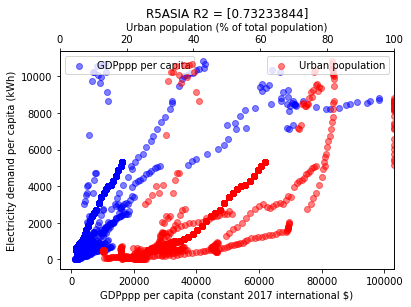

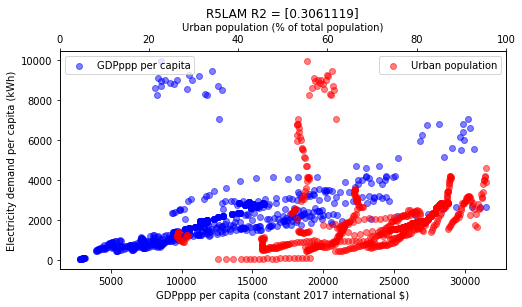

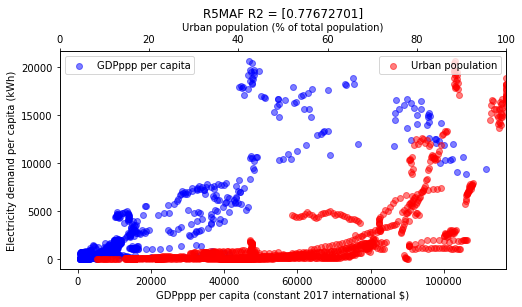

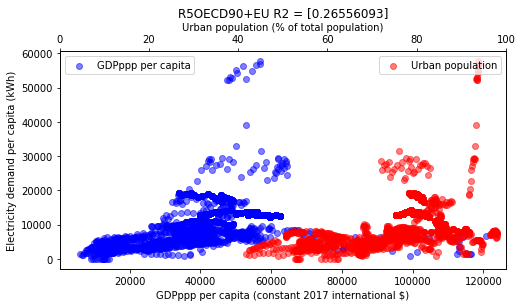

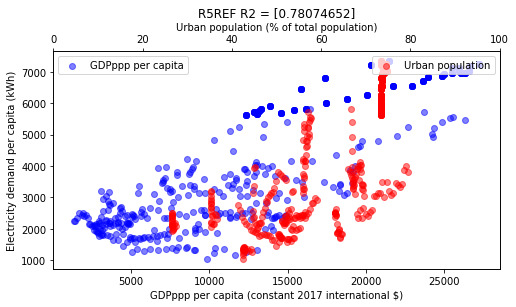

In [16]:
for a in country_regression_grouped.index.unique():
    country_regression_plot = country_regression_grouped.loc[a]
    b = country_regression_plot['WB_GDPppp']
    c = country_regression_plot['OWID_CON']
    x = country_regression_plot.loc[a , 'WB_GDPppp']
    m = country_regression_plot.loc[a , 'coef_GDPppp']
    z = country_regression_plot.loc[a , 'intercept']
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(b , c , color = 'blue' , alpha = 0.5 , label = 'GDPppp per capita')
    
    if urbanization == 'Yes':
        
        w2 = country_regression_plot.loc[a , 'R2_GDPppp_URB/CON'].unique()
        m2 = country_regression_plot.loc[a , 'coef_URB']
        d = country_regression_plot['WB_URB']
        ax2 = ax1.twiny()
        ax2.set_xlim(0 , 100)
        ax2.scatter(d , c , color = 'red' , alpha = 0.5 , label = 'Urban population') 
        ax2.set_xlabel('Urban population (% of total population)')
        ax2.legend(loc = 'upper right')
        plt.title(f'{a} R2 = {w2}')
        
    else:
        ax1.plot(x , m * x + z , color = 'blue' , alpha = 0.5) 
        w = country_regression_plot.loc[a , 'R2_GDPppp/CON'].unique()
        plt.title(f'{a} R2 = {w}')
    
    ax1.legend(loc='upper left')
    ax1.set_xlabel('GDPppp per capita (constant 2017 international $)')
    ax1.set_ylabel('Electricity demand per capita (kWh)')
    plt.rcParams["figure.figsize"] = [8,4]
    plt.show()

### III) Uses historic relationships and country-level SSP projections to project country-level electricity demand

In [17]:
#Retrieves countries for which both GDP and POP data is available within the World Bank API. 
intersection_raw = list(set(country_GDP_raw.index.intersection(country_POP_raw.index)))

#Sets the memberships dataframe solely for the above countries. 
country_demand_raw = import_spatial_mapping[['country' , 'region']].copy()
    
country_demand_raw = country_demand_raw[country_demand_raw['country'].isin(intersection_raw)
                                       ].drop_duplicates().set_index('country')

#Divides the country level GDP|PPP data (converted from billions to millions) with the population (millions) to get GDP|PPP pp.
country_demand_raw[f'{snapshot_year}_GDP|PPPpp_raw'] = (country_GDP_raw[snapshot_year] * 1000) / country_POP_raw[snapshot_year]

#Projects country-level projected demand pp (in kWh) based on multivariable linear regression if urbanization is included.
if urbanization == 'Yes':  

    country_demand_raw = pd.merge(country_demand_raw, country_regression_grouped[['coef_GDPppp' , 'coef_URB' , 'intercept']] 
                                  , left_on = 'region' , right_index = True)
    
    country_demand_raw[f'{snapshot_year}_URB_raw'] = country_URB_raw[snapshot_year]
    
    country_demand_raw[f'{snapshot_year}_demandpp_raw'] = country_demand_raw[
        'coef_GDPppp'] * country_demand_raw[f'{snapshot_year}_GDP|PPPpp_raw'
                                           ] + country_demand_raw['coef_URB'
                                                                 ] * country_demand_raw[f'{snapshot_year}_URB_raw'
                                                                                       ] + country_demand_raw['intercept']
    
#Projects country-level projected demand pp (in kWh) based on linear regression if urbanization is not included.
else:

    country_demand_raw = pd.merge(country_demand_raw, 
                                  country_regression_grouped[['coef_GDPppp' , 'intercept']] , 
                                  left_on = 'region' , right_index = True)
    
    country_demand_raw[f'{snapshot_year}_demandpp_raw'] = country_demand_raw['coef_GDPppp'
                                                                       ] * country_demand_raw[f'{snapshot_year}_GDP|PPPpp_raw'
                                                                                             ] + country_demand_raw['intercept']

country_demand_raw = country_demand_raw.drop_duplicates()

#Multiplies projected demand pp (in kWh) with population (in millions) to get country-level total projected demand (in MWh).
country_demand_raw[f'{snapshot_year}_demand_total_raw'] = country_demand_raw[f'{snapshot_year}_demandpp_raw'
                                                                       ] * (country_POP_raw[snapshot_year]) * 1000

country_demand_raw.head(1)

,region,2050_GDP|PPPpp_raw,coef_GDPppp,coef_URB,intercept,2050_URB_raw,2050_demandpp_raw,2050_demand_total_raw
country,,,,,,,,
AFG,R5ASIA,4182.581324,0.058052,76.051465,-1512.874039,43.339553,2025.969913,1.522759e+08


### IV) Creates weights dataframe for downscaling of the scenario specific regional Final Energy|Electricity data

In [18]:
country_demand_raw_weight = country_demand_raw[[f'{snapshot_year}_demand_total_raw']
                                              ].copy().rename(columns = {f'{snapshot_year}_demand_total_raw' : snapshot_year})

country_demand_raw_weight.index.names = ['region']

country_demand_raw_weight ['year'] = snapshot_year

country_demand_raw_weight = country_demand_raw_weight.pivot_table(index = 'region' , values = snapshot_year , columns = 'year')

country_demand_raw_weight.head(1)

year,2050
region,
AFG,1.522759e+08


### V) Extracts scenario specific demand and transmission loss variables (where applicable)

In [19]:
import_region_final_demand_scenario = {}
import_region_secondary_demand_scenario = {}
import_year_transmission_losses_scenario = {}
region_demand_scenario = {}
peak_demand_ratio_scenario = {}

for a in entries:

    #Sets seperate copy for the scenario specific regional electricity demand/losses dataframes and filters the relevant rows

    import_region_final_demand_scenario[a] = import_year_scenario[a].copy().loc[(import_year_scenario[a]['region'] != 
                                                                             'World') & 
                                                                            (import_year_scenario[a]['variable'] == 
                                                                             'Final Energy|Electricity')]
    
    import_region_secondary_demand_scenario[a] = import_year_scenario[a].copy().loc[(import_year_scenario[a]['region'] != 
                                                                         'World') & 
                                                                        (import_year_scenario[a]['variable'] == 
                                                                         'Secondary Energy|Electricity')]
        
    import_year_transmission_losses_scenario[a] = import_scenario[a].copy().loc[(import_scenario[a]['region'] != 
                                                                         'World') & 
                                                                        (import_scenario[a]['variable'] == 
                                                                        'Secondary Energy|Electricity|Transmission Losses')]
    
    if electricity_demand_type == 'Final Energy|Electricity':
        region_demand_scenario[a] = import_region_final_demand_scenario[a].copy().set_index(['region', 'model', 'scenario'])
    
        if len(import_year_transmission_losses_scenario[a].index) != 0:
            
            region_demand_scenario[a]['value'] = region_demand_scenario[a]['value'] + \
                                                        import_year_transmission_losses_scenario[a].set_index([
                                                            'region', 'model', 'scenario'])['value']
            
    if electricity_demand_type == 'Secondary Energy|Electricity':
        region_demand_scenario[a] = import_region_secondary_demand_scenario[a].copy().set_index(['region', 'model', 'scenario'])
            
        if len(import_year_transmission_losses_scenario[a].index) != 0:
            
            region_demand_scenario[a]['value'] = region_demand_scenario[a]['value'] - \
                                                        import_year_transmission_losses_scenario[a].set_index([
                                                            'region', 'model', 'scenario'])['value']
        
    #Converts pd.DataFrames to IamDataFrames to be able to use the PYAM downscale_region function.
    region_demand_scenario[a] = pyam.IamDataFrame(region_demand_scenario[a])

region_demand_scenario[a].head(1)

,model,scenario,region,variable,unit,year,value
0,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,R5ASIA,Final Energy|Electricity,EJ/yr,2050,52.904648


### VI) Downscales scenario specific regional Final Energy|Electricity to country-level

In [20]:
country_demand_scenario = {}

for a in entries:

    #Loops through the keys (regions) and values (countries) in mapping dictionary.
    for key, value in mapping_countries.items():
    
        #Filters the relevant weights (projected country-level electricity demand) based on the value entries (countries) 
        #for the specific key (region).
        weight = country_demand_raw_weight.copy()[country_demand_raw_weight.index.isin(value)]
        
        if len(weight.index) == 1:
            weight.loc[f'temp_{key}'] = [0]
            value.append(f'temp_{key}')
            
        if len(weight.index) == 0:
            weight.loc[f'temp_{key}'] = [0]
            weight.loc[value[0]] = [1]
            value.append(f'temp_{key}')
    
        #Downscales the IAM scenario electricity demand per region (key) to country level (value) by using the weights as proxy.
        region_demand_scenario[a].downscale_region(electricity_demand_type , region = key , subregions = value , 
                                                   weight = weight , append = True)
    
    #Excludes the regional values from the final IamDataFrames
    country_demand_scenario[a] = region_demand_scenario[a].filter(
        region = list(dict_countries.keys()) , 
        keep = True).timeseries().reset_index().set_index('region').rename(columns = {snapshot_year : 
                                                                                      f'country_{snapshot_year}'})

country_demand_scenario[a].head(1)

,model,scenario,variable,unit,country_2050
region,,,,,
AFG,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,Final Energy|Electricity,EJ/yr,0.408669


### VII) Adds or substracts transmission and distribution losses to/from scenario specific country-level demand

In [21]:
country_demand_losses_scenario = {}

for a in entries:
    
    if len(import_year_transmission_losses_scenario[a].index) == 0:

        #Merges demand dataframe with losses dataframe and calculates scenario specific country-level demand including losses.
        country_demand_losses_scenario[a] = pd.merge(country_demand_scenario[a] , 
                                                     import_losses [['country' , f'losses_%_{snapshot_year}']] , 
                                                     left_index = True , right_on = 'country').set_index('country')

        if electricity_demand_type == 'Final Energy|Electricity':

            country_demand_losses_scenario[a][
                f'country_{snapshot_year}'] = country_demand_losses_scenario[a][
                f'country_{snapshot_year}'] * country_demand_losses_scenario[a][
                f'losses_%_{snapshot_year}'] / 100 + country_demand_losses_scenario[a][
                f'country_{snapshot_year}']

        if electricity_demand_type == 'Secondary Energy|Electricity':

            country_demand_losses_scenario[a][
                f'country_{snapshot_year}'] = country_demand_losses_scenario[a][
                f'country_{snapshot_year}'] - (country_demand_losses_scenario[a][
                f'country_{snapshot_year}'] * country_demand_losses_scenario[a][
                f'losses_%_{snapshot_year}'] / 100)
    
    else:
        country_demand_losses_scenario[a] = country_demand_scenario[a]

    #Converts unit from EJ/yr to MWh/yr (1 EJ = 277778 GWh or 277778 * 1000 MWh).
    country_demand_losses_scenario[a][f'country_{snapshot_year}'] = country_demand_losses_scenario[
        a][f'country_{snapshot_year}'].apply(lambda x: x * 277778 * 1000)
   
    country_demand_losses_scenario[a]['unit'] = 'MWh/yr'

country_demand_losses_scenario[entries[-1]].head(1)

,model,scenario,variable,unit,country_2050,losses_%_2050
country,,,,,,
AFG,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,Final Energy|Electricity,MWh/yr,1.219331e+08,7.411865


### VIII) Determines relative 2015 share of demand per sub-country node used to decompose country-level scenario specific electricity demand

In [22]:
#Sums the hourly demand as retrieved from the PLEXOS-World dataset to year total (in MWh) and drops all hourly values.
demand_2015_raw = import_hourly_demand_2015.drop(columns = ['Datetime'])

demand_2015_raw.loc['node_demand_2015'] = demand_2015_raw.sum()

demand_2015_raw = demand_2015_raw.iloc[8760:].transpose().reset_index().rename(columns = {'index' : 'node'})

#Checks whether all countries as included for the modelling are also in the 2015 dataset and if not it adds entries manually.
#NA replaced with 1 to indicate 'share_%_country_demand' to be the full country.
demand_2015_missing = import_spatial_mapping.node[(~import_spatial_mapping.node.isin(demand_2015_raw.node))]

demand_2015_raw = pd.concat([demand_2015_raw, demand_2015_missing]).fillna(1)

#Adds country entry to dataframe (e.g. NA-USA-CA node gets column entry NA-USA country)
demand_2015_raw.insert(loc = 0 , column = 'country' , value = demand_2015_raw['node'].str[:6])

#Creates a dataframe excluding all sub-country nodes
country_demand_2015 = demand_2015_raw[demand_2015_raw['country'] == demand_2015_raw['node']
                                     ].drop(columns = ['node']
                                           ).rename(columns = {'node_demand_2015' : 'country_demand_2015'})

#Adds country-level 2015 demand in column adjacent to sub-country level 2015 demand and calculates relative share per country.
node_demand_2015 = pd.merge(demand_2015_raw , country_demand_2015[['country' , 'country_demand_2015']] , 
                             on = 'country' , how ='left').dropna()

node_demand_2015['share_%_country_demand'] = node_demand_2015['node_demand_2015'] / node_demand_2015['country_demand_2015']
node_demand_2015['country'] = demand_2015_raw['country'].str[3:6]

node_demand_scenario = {}

for a in entries:

    #Drops the non-required columns and merges the 2015 and 2050 demand dataframes
    node_demand_scenario[a] = pd.merge(country_demand_losses_scenario[a][['model' , 'scenario' , 'variable' , 'unit' , 
                                                                          f'country_{snapshot_year}']] , 
                                       node_demand_2015[['country' , 'node' , 'share_%_country_demand']] , 
                                       left_index = True , right_on = 'country').set_index('node')

    #Multiplies the sub-country share of 2015 demand by the calculated 2050 demand to retrieve the 2050 final demand including
    #losses for all nodes (in MWh).
    node_demand_scenario[a][f'node_{snapshot_year}_incl_losses'
                           ] = (node_demand_scenario[a][f'country_{snapshot_year}'] * \
                                node_demand_scenario[a]['share_%_country_demand']).round(2)

    #Filters out country rows for countries with sub-country nodes. 
    node_demand_scenario[a] = node_demand_scenario[a][node_demand_scenario[a].index.isin(import_spatial_mapping.node)]

node_demand_scenario[entries[-1]].loc[node_demand_scenario[entries[-1]].index == 'NA-CAN-QC']

,model,scenario,variable,unit,country_2050,country,share_%_country_demand,node_2050_incl_losses
node,,,,,,,,
NA-CAN-QC,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,Final Energy|Electricity,MWh/yr,4.777626e+08,CAN,0.334204,1.596703e+08


### IX) Constrains negative values to 2015 baseline values as minimum

In [23]:
node_demand_scenario_clip = {}

for a in entries:

    node_demand_scenario_clip[a] = pd.DataFrame()

    for b in node_demand_scenario[a].index.unique():
        
        node_demand_scenario_temp = node_demand_scenario[a].loc[node_demand_scenario[a].index == b]

        node_demand_2015_temp = node_demand_2015[node_demand_2015['node'].str.contains(b)]
        
        if node_demand_scenario_temp[f'node_{snapshot_year}_incl_losses'].iloc[0] <= 0:
            
            print(f'{b} demand below 0. Value clipped to 2015 value.')
        
            node_demand_scenario_temp.loc[b, f'node_{snapshot_year}_incl_losses'] = node_demand_scenario_temp[
                f'node_{snapshot_year}_incl_losses'].iloc[0].clip(node_demand_2015_temp.iloc[0]['node_demand_2015'])

        node_demand_scenario_clip[a] = pd.concat([node_demand_scenario_clip[a], pd.DataFrame(node_demand_scenario_temp)])

    node_demand_scenario_clip[a] = node_demand_scenario_clip[a][node_demand_scenario[a].columns
                                                       ].drop(columns = {f'country_{snapshot_year}'})
    
    node_demand_scenario_clip[a] = node_demand_scenario_clip[a].astype({f'node_{snapshot_year}_incl_losses' : np.int64})

node_demand_scenario_clip[entries[-1]].loc[node_demand_scenario_clip[entries[-1]].index == 'NA-CAN-QC']

,model,scenario,variable,unit,country,share_%_country_demand,node_2050_incl_losses
node,,,,,,,
NA-CAN-QC,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,Final Energy|Electricity,MWh/yr,CAN,0.334204,159670298


### X Rescales clipped demand values to regional scenario values

In [24]:
node_demand_scenario_final = {}

for a in entries:
    
    col = f'node_{snapshot_year}_incl_losses'
    
    node_demand_scenario_final[a] = node_demand_scenario_clip[a].copy()
    
    #Sets the demand DF with clipped values and adds original values (unclipped) and its associated IAM regions.
    node_demand_scenario_final[a]['original'] = node_demand_scenario[a].copy()[col]
    node_demand_scenario_final[a]['IAM_region'] = node_demand_scenario_final[a].index.map(dict_nodes)
    
    for country in node_demand_scenario_final[a]['country'].unique():
        tempdf = node_demand_scenario_final[a].loc[node_demand_scenario_final[a]['country'] == country]
        
        #For countries where the original values were <= 0 a scaler is calculated to decrease the demand for all other 
        #countries within the relevant IAM region to compensate for the clipped values to 2015 levels. I.e. this leads to 
        #the sum of the demands for all countries within a IAM region equal the regional scenario value after clipping.
        if (tempdf['original'] <= 0).any():
            iamregion = tempdf['IAM_region'].iloc[0]
            tempdf2 = node_demand_scenario_final[a].loc[(node_demand_scenario_final[a]['original'] <= 0) & 
                                                       (node_demand_scenario_final[a]['IAM_region'] == 
                                                       iamregion)]
            
            tempdf3 = node_demand_scenario_final[a].loc[(node_demand_scenario_final[a]['original'] >= 0) & 
                                                        (node_demand_scenario_final[a]['IAM_region'] == 
                                                         iamregion)]

            scaler = tempdf3['original'].sum() / (tempdf3['original'].sum() - 
                                                  ((tempdf2['original'].sum() * -1) +  tempdf2[col].sum()))
   
            node_demand_scenario_final[a].loc[
                (node_demand_scenario_final[a]['original'] >= 0) & 
                (node_demand_scenario_final[a]['IAM_region'] == 
                 iamregion), col] = node_demand_scenario_final[a].loc[
                                                       (node_demand_scenario_final[a]['original'] >= 0) & 
                                                       (node_demand_scenario_final[a]['IAM_region'] == 
                                                        iamregion), col].div(scaler)
    
            print(f'{country} demand below 0 and set to 2015 levels. Demand decreased for all other countries in {iamregion}')
    
  #  node_demand_scenario_final[a] = node_demand_scenario_final[a].drop(columns = {'original', 'IAM_region'})
    
node_demand_scenario_final[entries[-1]].loc[node_demand_scenario_final[entries[-1]].index == 'NA-CAN-QC']

,model,scenario,variable,unit,country,share_%_country_demand,node_2050_incl_losses,original,IAM_region
node,,,,,,,,,
NA-CAN-QC,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,Final Energy|Electricity,MWh/yr,CAN,0.334204,159670298,1.596703e+08,R5OECD90+EU


### XI) Determines peak demand per node

In [25]:
node_peak_demand_scenario = {}

#Calculates 2015 max, min and sum per node.
node_peak_demand_2015 = pd.DataFrame(list(zip(import_hourly_demand_2015.max() , import_hourly_demand_2015.min() , 
                                              import_hourly_demand_2015.sum() , import_hourly_demand_2015)) , 
                                     columns = ['2015_max' , '2015_min' , '2015_sum' , 'node']
                                    ).iloc[1:].set_index('node')

#Calculates 2015 peak demand / sum demand ratio
node_peak_demand_2015['2015_ratio_max/sum'] = node_peak_demand_2015['2015_max'] / node_peak_demand_2015['2015_sum']
node_peak_demand_2015['2015_ratio_min/sum'] = node_peak_demand_2015['2015_min'] / node_peak_demand_2015['2015_sum']

#Countries that weren't included in the 2015 dataset get assigned an dataset average peak demand ratio.
node_peak_demand_2015['2015_ratio_max/sum'] = node_peak_demand_2015['2015_ratio_max/sum'].fillna(
    node_peak_demand_2015['2015_ratio_max/sum'].mean() , inplace = False)

node_peak_demand_2015['2015_ratio_min/sum'] = node_peak_demand_2015['2015_ratio_min/sum'].fillna(
    node_peak_demand_2015['2015_ratio_min/sum'].mean() , inplace = False)

#Adds IAM region
node_peak_demand_2015['IAM_region'] = node_peak_demand_2015.index.map(dict_nodes)

#Calculates regional 2015 values
node_peak_demand_2015['2015_sum_regional'] = node_peak_demand_2015['2015_sum'].groupby(node_peak_demand_2015['IAM_region']
                                                                                      ).transform('sum')

node_peak_demand_2015['2015_max_regional'] = node_peak_demand_2015['2015_max'].groupby(node_peak_demand_2015['IAM_region']
                                                                                      ).transform('sum')

node_peak_demand_2015['2015_ratio_max/sum_regional'] = node_peak_demand_2015['2015_max_regional'
                                                                            ] / node_peak_demand_2015['2015_sum_regional']

for a in entries:
    
    #Combines 2015 and snapshot_year demand datafiles.
    node_peak_demand_scenario[a] = pd.merge(node_peak_demand_2015 , node_demand_scenario_final[a] , 
                                         left_index = True , right_index = True , how = 'right')

    node_peak_demand_scenario[a][f'{snapshot_year}_multiplier'] = peak_load_max

    #Calculates nodal peak demand. 
    node_peak_demand_scenario[a][f'{snapshot_year}_max'] = (node_peak_demand_scenario[a][
        f'node_{snapshot_year}_incl_losses'] * node_peak_demand_scenario[a][
        f'{snapshot_year}_multiplier'].astype(float) * node_peak_demand_scenario[a]['2015_ratio_max/sum']).round(2)
    
    #Cleans up dataframe.
    node_peak_demand_scenario[a] = node_peak_demand_scenario[a].reset_index().rename(columns = {'node' : 'region' ,  
                                                                                      f'node_{snapshot_year}_incl_losses' : 
                                                                                      f'demand_total_{snapshot_year}'})
    
    #Adds minimum load value in case hourly demand profiles need to be generated (only possible with linear scaling).
    if hourly_demand_generator == 'Yes' and peak_load_max == 1:
        node_peak_demand_scenario[a][f'{snapshot_year}_min'] = (node_peak_demand_scenario[a][
            f'demand_total_{snapshot_year}'].astype(float) * node_peak_demand_scenario[a]['2015_ratio_min/sum'
                                                                                         ].astype(float)).round(2)
        
    #Extracts relevant columns.
        node_peak_demand_scenario[a] = node_peak_demand_scenario[a][['model' , 'scenario' , 'region' , 'variable' , 
                                                                 'unit' , f'demand_total_{snapshot_year}', 
                                                                 f'{snapshot_year}_max' , f'{snapshot_year}_min']
                                                               ].sort_values(by = ['region'])
        
    else:
        node_peak_demand_scenario[a] = node_peak_demand_scenario[a][['model' , 'scenario' , 'region' , 'variable' , 
                                                                 'unit' , f'demand_total_{snapshot_year}', 
                                                                 f'{snapshot_year}_max']].sort_values(by = ['region'])
    
node_peak_demand_scenario[entries[-1]].loc[node_peak_demand_scenario[entries[-1]]['region'] == 'NA-CAN-QC']

,model,scenario,region,variable,unit,demand_total_2050,2050_max
37,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,NA-CAN-QC,Final Energy|Electricity,MWh/yr,159670298,33332.33


### XII) Creates scaled hourly demand profiles

In [26]:
if hourly_demand_generator == 'Yes' and peak_load_max == 1:
    
    hourly_demand_scaled = {}
  
    for a in entries:

        hourly_demand_scaled[a] = import_hourly_demand_2015.copy()

        for b in node_peak_demand_scenario[entries[-1]].region.unique():
     
            peak_max = node_peak_demand_scenario[a].loc[node_peak_demand_scenario[a].region == 
                                                    b].iloc[0][f'{snapshot_year}_max']

            peak_min = node_peak_demand_scenario[a].loc[node_peak_demand_scenario[a].region == 
                                                    b].iloc[0][f'{snapshot_year}_min']

            scaler = MinMaxScaler(feature_range = (peak_min , peak_max))

            hourly_demand_scaled[a][[b]] = scaler.fit_transform(hourly_demand_scaled[a][[b]]).round(0)
            
        hourly_demand_scaled[a] = hourly_demand_scaled[a].set_index('Datetime')
        hourly_demand_scaled[a].index = hourly_demand_scaled[a].index.str.replace('/2015', f'/{snapshot_year}')
    
else:

    print('Hourly profiles not created because hourly_demand_generator != Yes and/or No peak_load_max != 1.')

Hourly profiles not created because hourly_demand_generator != Yes and/or No peak_load_max != 1.


## Calculates region- and fuel type specific expansion and retirement constraints
In the following section regional and fuel type specific expansion and retirement constraints are created by comparing the baseline generator capacities (based on the 2015 PLEXOS-World model) and the scenario specific generator capacities for the given scenario year following reported values in the IAM database.

Based on the set of constraints per region, the Long Term capacity expansion Module in PLEXOS-World (or different tool) optimizes the allocation and retirement of generator capacities for all nodes by making use of its local characteristics (existing capacities, potential for renewables etc.). At all times, the cumulatively installed and retired generator capacity within the different nodes per region equals the reported regional capacities for the specific IAM scenario. This approach allows for improving the spatial resolution of the regional representation as well as co-optimize the expansion of supporting assets such as transmission infrastructure and electricity storage. Note that within the current framework no costs are attached to the allocation of generator capacities since this is already considered in the IAM. Refer to the journal paper as referenced at the beginning of the script for further details.

<B>The following steps are taken;</B>

<B>I)</B> 2015 baseline capacities are extracted from the 2015 PLEXOS-World model (over 30,000 seperate power plants) and grouped per fuel type and node.

<B>II)</B> The fuel types as used in the 2015 PLEXOS-World model are linked to Capacity|Electricity variables as used in the IAM database and the 2015 baseline capacities are grouped per variable type and node. The mapping between PLEXOS-World 2015 fuel types and IAM variables has to be pre-specified in the 'memberships.xlsx PLEXOS_World_2015_fuel_mapping' sheet.

<B>III)</B> 2015 baseline capacities are grouped per variable type and region to create regional baseline capacities.

<B>IV)</B> Dataframe is created with the Capacity|Electricity variables for the given IAM scenario and the specific scenario year.

<B>V)</B> Not all scenario's in the IAM databases have differentiated Capacity|Electricity for thermal plants (w/ & w/o CCS) Solar (PV, CSP) and wind (Onshore, Offshore). Cell checks whether variables are differentiated in the specific IAM scenario and adjusts the entries accordingly assuming that if the category is not differentiated the full capacity can be allocated to the most common technology (w/o CCS, Solar|PV and Wind|Onshore). Furthermore, where deemed appropriate, IAM variable categories are grouped into correct power system model technology entries. Both aspects have to be pre-specified in the 'memberships.xlsx technology_mapping' sheet. Refer to the 'Custom Input' section at the beginning of this script for more details.

<B>VI)</B> The regional 2015 baseline capacities are compared to the scenario capacities for the specific year. Sets of expansion and retirement constraints are created specific per region and Capacity|Electricity variable. If the regional 2015 baseline capacity for a specific Capacity|Electricity variable is lower than the reported value for the given scenario year it means that expansion is required and vice versa retirement. 

### I) Calculates generator level total capacity in MW for all generators in the 2015 PLEXOS-World model

In [27]:
#Pulls out the number of generator units per powerplant in the 2015 PLEXOS-World model. Note that it also includes known 
#powerplants that were build after 2015 (yet are not included in model simulations for the 2015 calendar year in PLEXOS-World.)
PLEXOS_2015_generator_units = import_PLEXOS_2015_properties.loc[(import_PLEXOS_2015_properties['child_class'] == 'Generator') &
                                                                (import_PLEXOS_2015_properties['property'] == 'Units') &
                                                                (import_PLEXOS_2015_properties['value'] != 0)]

#Pulls out the max capacity per generator unit per powerplant in the 2015 PLEXOS-World model.
PLEXOS_2015_generator_max_capacity = import_PLEXOS_2015_properties.loc[(import_PLEXOS_2015_properties['child_class'] == 
                                                                        'Generator') & 
                                                                       (import_PLEXOS_2015_properties['property'] == 
                                                                        'Max Capacity')]
#Merges the units and max_capacity dataframes
PLEXOS_2015_generator_capacity = pd.merge(PLEXOS_2015_generator_units , 
                                           PLEXOS_2015_generator_max_capacity [['property' , 'value' , 'child_object']] , 
                                           on = 'child_object' , how ='left')

#Adds fuel type as seperate column
PLEXOS_2015_generator_capacity.insert(2 , 'fuel' , PLEXOS_2015_generator_capacity['child_object'].str.split('_').str[1])

#Renames the default column headers and drops non-required columns
PLEXOS_2015_generator_capacity = PLEXOS_2015_generator_capacity.rename(columns = {'value_x' : 'units' , 
                                                                                  'value_y' : 'max_capacity'
                                                                                 }).drop(columns = ['property_x' , 
                                                                                                    'property_y'])

#Multiplies the number of units with the capacity per unit to return total capacity per generator
PLEXOS_2015_generator_capacity['2015_total_capacity'] = PLEXOS_2015_generator_capacity ['units'] *\
                                                    PLEXOS_2015_generator_capacity ['max_capacity']

#Pulls out the memberships of the generators with its related node. 
PLEXOS_2015_memberships_generator_node = import_PLEXOS_2015_memberships.loc[
    (import_PLEXOS_2015_memberships['parent_class'] == 'Generator') & 
    (import_PLEXOS_2015_memberships['child_class'] == 'Node'
    )].rename(columns = {'child_object' : 'node' , 'parent_object' : 'child_object'})

#Merges the memberships with the generator capacity dataframe
PLEXOS_2015_generator_capacity = pd.merge(PLEXOS_2015_generator_capacity , 
                                          PLEXOS_2015_memberships_generator_node[['child_object' , 'node']] , 
                                          on  = 'child_object' , how ='left')

PLEXOS_2015_generator_capacity.tail(1)

,child_class,child_object,fuel,units,max_capacity,2015_total_capacity,node
30657,Generator,ZWE_Hyd_KaribaDamSout29911,Hyd,2.0,375.0,750.0,AF-ZWE


### II) Links fuel entries in the 2015 PLEXOS-World model with generator technology groups from IAM databases

In [28]:
#Distinguishes 'Gas' category into CCGT (>=130 MW power plants) and OCGT (<130 MW power plants) in line with PLEXOS-World.
PLEXOS_2015_generator_capacity.loc[(PLEXOS_2015_generator_capacity['2015_total_capacity'] >= 130) &
                                       (PLEXOS_2015_generator_capacity['fuel'] == 'Gas') , 'fuel'] = 'Ccg'

PLEXOS_2015_generator_capacity.loc[(PLEXOS_2015_generator_capacity['2015_total_capacity'] < 130) &
                                       (PLEXOS_2015_generator_capacity['fuel'] == 'Gas') , 'fuel'] = 'Ocg'

#Links the different fuel entries in the 2015 PLEXOS-World model with generator groups as required for the power system model
#input. #The specified mapping can be changed in the 'memberships' excel file in the 'PLEXOS_World_2015_fuel_mapping' sheet. 
fuels_conversion = import_memberships_fuels_PW2015.copy().rename(columns = {'PW2015_fuel' : 'fuel'})
fuels_conversion['variable'] = 'Capacity|Electricity|' + import_memberships_fuels_PW2015['PSM']

#Adds the IAM database 'variable' to the capacity dataframe.
PLEXOS_2015_generator_capacity = pd.merge(PLEXOS_2015_generator_capacity , 
                                          fuels_conversion[['fuel' , 'variable']] , on = 'fuel' , how ='left')

PLEXOS_2015_generator_capacity.tail(4)

,child_class,child_object,fuel,units,max_capacity,2015_total_capacity,node,variable
30654,Generator,ZWE_Coa_Capacity Scaler,Coa,2.0,157.5,315.0,AF-ZWE,Capacity|Electricity|Coal|w/o CCS
30655,Generator,ZWE_Coa_HwangeCoalPow29910,Coa,4.0,230.0,920.0,AF-ZWE,Capacity|Electricity|Coal|w/o CCS
30656,Generator,ZWE_Hyd_Capacity Scaler,Hyd,1.0,40.0,40.0,AF-ZWE,Capacity|Electricity|Hydro
30657,Generator,ZWE_Hyd_KaribaDamSout29911,Hyd,2.0,375.0,750.0,AF-ZWE,Capacity|Electricity|Hydro


### III) Aggregates 2015 generator capacity per variable group and IAM region and adds IAM scenario regional representation to dataframe

In [29]:
#Groups capacity based on the variable entries.
PLEXOS_2015_generator_capacity_grouped_fuel = PLEXOS_2015_generator_capacity.groupby(['variable','node'
                                                                                     ]).agg({'2015_total_capacity' : 'sum'
                                                                                            }).reset_index()
#Adds IAM scenario regional representation to PLEXOS_nodes
PLEXOS_2015_generator_capacity_grouped_fuel = pd.merge(PLEXOS_2015_generator_capacity_grouped_fuel , 
                                                             import_spatial_mapping [['node' , 'region']] , 
                                                             on = 'node' , how = 'left')

#Drops data from nodes that are in the 2015 PLEXOS-World model yet not included for the IAM scenario and rounds to 0 decimals.
PLEXOS_2015_generator_capacity_grouped_fuel.dropna(axis = 0 , how = 'any' , inplace = True)

#Groups capacity per scenario region and resets the index to return variables as column and not as index.
PLEXOS_2015_generator_capacity_grouped_region = PLEXOS_2015_generator_capacity_grouped_fuel.groupby([
    'variable','region']).agg({'2015_total_capacity' : 'sum'}).reset_index()

#converts to GW.
PLEXOS_2015_generator_capacity_grouped_region['2015_total_capacity'] = (PLEXOS_2015_generator_capacity_grouped_region[
    '2015_total_capacity'] / 1000)

PLEXOS_2015_generator_capacity_grouped_region.head(1)

,variable,region,2015_total_capacity
0,Capacity|Electricity|Biomass|w/o CCS,R5ASIA,24.906376


### IV) Creates dataframe with IAM scenario and year specific Capacity|Electricity variables for the simulation year with power system model naming conventions

In [30]:
year_generator_capacity = {}

for a in entries:

    #Excludes 'World' from the scenario specific regional capacity dataframe
    year_generator_capacity[a] = import_year_scenario_generator_capacity[
        a][import_year_scenario_generator_capacity[a].region.isin(import_spatial_mapping.region)].rename(columns = {'value' : 
                                                                                           f'{snapshot_year}_total_capacity'})
    
    year_generator_capacity[a] = year_generator_capacity[a][year_generator_capacity[a].variable
                                                            .isin(dict_technologies_capacity_variable.keys())]  
    
    #Replaces the IAM entries with to be used power system model naming conventions. 
    for b, c in dict_technologies_capacity_variable.items():
        
        year_generator_capacity[a].replace([b] ,  [c] , inplace=True)
            
    year_generator_capacity[a] = year_generator_capacity[a].groupby(['model' , 'scenario' , 'variable' , 
                                                                     'unit' , 'region' , 'year']).sum().reset_index()
    
    year_generator_capacity[a] = year_generator_capacity[a].loc[~year_generator_capacity[a]['variable'].str.contains('Exclude')]

year_generator_capacity[entries[-1]].head(1)

,model,scenario,variable,unit,region,year,2050_total_capacity
0,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,Capacity|Electricity|Biomass|w/o CCS,GW,R5ASIA,2050,632.314181


### VI) Merges the baseline and scenario specific capacity dataframes and creates expansion and retirement constraint values

In [31]:
expansion_constraints = {}

for a in entries:

    #Merges dataframes together
    expansion_constraints[a] = pd.merge(PLEXOS_2015_generator_capacity_grouped_region , year_generator_capacity[a] , 
                                      on = ['variable' , 'region'] , how ='outer'
                                        ).fillna(0).sort_values(by = ['variable' , 'region']).reset_index(drop = True)
    
    expansion_constraints[a]['model'] , expansion_constraints[a]['scenario'] = a.split("|",1)[0] , a.split("|",1)[1]
    expansion_constraints[a]['unit'] , expansion_constraints[a]['year'] = 'GW' , snapshot_year
    
    #Calculates the difference between 2015 and snapshot_year capacity, negative values represent a reduction in capacity.
    expansion_constraints[a]['dif_capacity'] = (expansion_constraints[a][
        f'{snapshot_year}_total_capacity'] - expansion_constraints[a]['2015_total_capacity']).round(1)

    #Specifies values for capacity expansion and retirement per region.
    expansion_constraints[a]['expansion'] = np.where(expansion_constraints[a].dif_capacity > 0 , 
                                                   expansion_constraints[a].dif_capacity , 0)

    expansion_constraints[a]['retirement'] = np.where(expansion_constraints[a].dif_capacity < 0 , 
                                                    - expansion_constraints[a].dif_capacity , 0)
    
    #Filters columns.
    expansion_constraints[a] = expansion_constraints[a][['model' , 'scenario' , 'region' , 'variable' , 'unit' , 'year' , 
                                                        '2015_total_capacity' , f'{snapshot_year}_total_capacity' , 
                                                        'expansion' , 'retirement']]
        
expansion_constraints[entries[-1]].head(1)

,model,scenario,region,variable,unit,year,2015_total_capacity,2050_total_capacity,expansion,retirement
0,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,R5ASIA,Capacity|Electricity|Biomass|w/o CCS,GW,2050,24.906376,632.314181,607.4,0.0


## Calculates region- and fuel type specific power plant efficiency and heat rates
Calculates technology thermal efficiencies and heat rates for scenario ensembles where Efficiency|Electricity variables are specified. Similar to calculation of capacities, technology entries within the IAM can be aggregated for the power system model if deemed appropriate (as pre-specified in the 'memberships.xlsx' technology_mapping sheet PSM_efficiency column). For example, if Gas|w/o CCS|2 and Gas|w/o CCS|3 are to be aggregated in a single category, this cell determines a capacity weighted average for efficiencies and heat rates based on the relative capacity size per seperate IAM technology for the specific scenario.

In [32]:
year_generator_efficiency = {}

for a in entries:

    #Excludes 'World' from the scenario specific regional efficiency dataframe.
    year_generator_efficiency[a] = import_year_scenario_generator_efficiency[
        a][import_year_scenario_generator_efficiency[a].region.isin(import_spatial_mapping.region)].rename(columns = {'value' : 
                                                                                           f'{snapshot_year}_efficiency'})
    
    #Temporarily changes variable name to be able to merge capacity and efficiency dataframes.
    year_generator_efficiency[a]['variable'] = year_generator_efficiency[a]['variable'].str.replace('Efficiency' , 'Capacity')
    
    year_generator_efficiency[a] = pd.merge(year_generator_efficiency[a] , import_year_scenario_generator_capacity[a]
                                            [['value' , 'variable' , 'region']] , left_on = ['variable' , 'region'] , 
                                            right_on = ['variable' , 'region'] , how = 'inner')
    
    year_generator_efficiency[a]['variable'] = year_generator_efficiency[a]['variable'].str.replace('Capacity' , 'Efficiency')
    
    #Replaces the IAM entries with to be used power system model naming conventions. 
    for b, c in dict_technologies_efficiency_variable.items():
        
        year_generator_efficiency[a].replace([b] ,  [c] , inplace=True)
    
    #Filters out to be excluded rows and rows where efficiency == 0 (e.g. renewables). 
    year_generator_efficiency[a] = year_generator_efficiency[a].loc[(~year_generator_efficiency[a]
                                                                    ['variable'].str.contains('Exclude')) & 
                                                                   (year_generator_efficiency[a]
                                                                    [f'{snapshot_year}_efficiency'] != 0)]
    
    #Sets groupby function per power system model input category and region.    
    x = year_generator_efficiency[a].groupby(['variable' , 'region'])
    
    #Calculates capacity weighted average efficiency per power system model input category and region.    
    year_generator_efficiency[a]['y'] = year_generator_efficiency[a][f'{snapshot_year}_efficiency'
                                                                    ] / x.value.transform('sum'
                                                                                         ) * year_generator_efficiency[a].value
    
    year_generator_efficiency[a]['efficiency'] = x.y.transform('sum')
    
    #Sets standard variable efficiency for entries with 0 capacity.         
    year_generator_efficiency[a]['efficiency'] = np.where(year_generator_efficiency[a].efficiency == 0 , 
                                                     x[f'{snapshot_year}_efficiency'].transform(np.mean) , 
                                                     year_generator_efficiency[a].efficiency).round(1)
    
    #Removes duplicate rows
    year_generator_efficiency[a] = year_generator_efficiency[a][['model' , 'scenario' , 'region' , 
                                                                 'variable' , 'unit' , 'year' , 'efficiency']].drop_duplicates()
    
    #Adds heat rate column (GJ/MWh , 3.6 GJ = 1 MWh ). 
    year_generator_efficiency[a]['heatrate'] = (100 / year_generator_efficiency[a].efficiency * 3.6).round(1)
    
    year_generator_efficiency[a]['unit'] = '% or GJ/MWh'
    
    #Prints warning message in case Efficiency|Electricity variables are not specified in the specific scenario ensemble. 
    if year_generator_efficiency[a].empty:
        print(f'Efficiency|Electricity not specified in {a} scenario ensemble!')

year_generator_efficiency[entries[-1]].head(1)

Efficiency|Electricity not specified in MESSAGE-GLOBIOM 1.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Efficiency|Electricity not specified in AIM/CGE 2.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Efficiency|Electricity not specified in IMAGE 3.0.1|ADVANCE_2020_1.5C-2100 scenario ensemble!


,model,scenario,region,variable,unit,year,efficiency,heatrate


## Extracts storage and hydrogen capacities from scenario output

In [33]:
year_storage_capacity = {}
year_hydrogen_electricity_capacity = {}
year_electricity_hydrogen_capacity = {}

for a in entries:

    year_storage_capacity[a] = import_year_scenario[a].loc[(import_year_scenario[a]['variable'] == 
                                                             'Capacity|Electricity|Storage') & 
                                                            (import_year_scenario[a]['region'] != 'World') & 
                                                            (import_year_scenario[a]['region'].isin(
                                                                list(set(dict_nodes.values()))))].round(1)

    year_hydrogen_electricity_capacity[a] = import_year_scenario[a].loc[(import_year_scenario[a]['variable'] == 
                                                              'Capacity|Hydrogen|Electricity') & 
                                                            (import_year_scenario[a]['region'] != 'World') & 
                                                            (import_year_scenario[a]['region'].isin(
                                                                list(set(dict_nodes.values()))))].round(1)
    
    year_electricity_hydrogen_capacity[a] = import_year_scenario[a].loc[(import_year_scenario[a]['variable'] == 
                                                              'Capacity|Electricity|Hydrogen') & 
                                                            (import_year_scenario[a]['region'] != 'World') & 
                                                            (import_year_scenario[a]['region'].isin(
                                                                list(set(dict_nodes.values()))))].round(1)
    
    #Prints warning message in case variables are not specified in the specific scenario ensemble. 
    if year_storage_capacity[a].empty:
        print(f'Capacity|Electricity|Storage not specified in {a} scenario ensemble!')
        
    if year_hydrogen_electricity_capacity[a].empty:
        print(f'Capacity|Hydrogen|Electricity not specified in {a} scenario ensemble!')

    if year_electricity_hydrogen_capacity[a].empty:
        print(f'Capacity|Electricity|Hydrogen not specified in {a} scenario ensemble!')
        
year_storage_capacity[entries[-1]].head(1)

Capacity|Electricity|Storage not specified in MESSAGE-GLOBIOM 1.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Capacity|Hydrogen|Electricity not specified in MESSAGE-GLOBIOM 1.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Capacity|Electricity|Hydrogen not specified in MESSAGE-GLOBIOM 1.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Capacity|Electricity|Storage not specified in AIM/CGE 2.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Capacity|Hydrogen|Electricity not specified in AIM/CGE 2.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Capacity|Electricity|Hydrogen not specified in AIM/CGE 2.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Capacity|Electricity|Storage not specified in IMAGE 3.0.1|ADVANCE_2020_1.5C-2100 scenario ensemble!
Capacity|Hydrogen|Electricity not specified in IMAGE 3.0.1|ADVANCE_2020_1.5C-2100 scenario ensemble!
Capacity|Electricity|Hydrogen not specified in IMAGE 3.0.1|ADVANCE_2020_1.5C-2100 scenario ensemble!


,model,scenario,variable,unit,region,year,value


## Sets scenario specific pricing data
Extracts the year and scenario specific carbon and fuel prices if available for the specified scenario ensemble.

In [34]:
price_carbon = {}
price_fuels = {}
price_hydrogen = {}

list_regions_world = list(set(dict_nodes.values()))
list_regions_world.append('World')

for a in entries:

    price_carbon[a] = import_year_scenario[a].loc[(import_year_scenario[a]['variable'] == 'Price|Carbon') & 
                                                  (import_year_scenario[a]['region'].isin(list_regions_world))].round(2)

    price_fuels[a] = import_year_scenario[a].loc[import_year_scenario[a]['variable'].str.contains('Price\|Primary Energy\|') & 
                                                 (import_year_scenario[a]['region'].isin(list_regions_world))].round(2)
    
    price_hydrogen[a] = import_year_scenario[a].loc[(import_year_scenario[a]['variable'] == 'Price|Secondary Energy|Hydrogen')
                                                    & (import_year_scenario[a]['region'].isin(list_regions_world))].round(2)
    
    #Prints warning message in case variables are not specified in the specific scenario ensemble.
    if price_carbon[a].empty:
        print(f'Carbon price not specified in {a} scenario ensemble!')
        
    if price_fuels[a].empty:
        print(f'Price|Primary Energy for fossil fuels not specified in {a} scenario ensemble!')
        
    if price_hydrogen[a].empty:
        print(f'Price|Secondary Energy|Hydrogen not specified in {a} scenario ensemble!')

price_fuels[entries[-1]].head(1)

Price|Secondary Energy|Hydrogen not specified in MESSAGE-GLOBIOM 1.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Price|Secondary Energy|Hydrogen not specified in AIM/CGE 2.0|ADVANCE_2020_1.5C-2100 scenario ensemble!
Price|Secondary Energy|Hydrogen not specified in IMAGE 3.0.1|ADVANCE_2020_1.5C-2100 scenario ensemble!


,model,scenario,variable,unit,region,year,value
23931,IMAGE 3.0.1,ADVANCE_2020_1.5C-2100,Price|Primary Energy|Coal,US$2010/GJ,World,2050,2.21


## Exports the downscaled and converted IAM scenario output data as input for the power system model soft-link

In [35]:
#Creates scenario subdirectory in output folder.
for a in entries:
        
    output = f'{a.split("|",1)[0]} {a.split("|",1)[1]}'
    
    for ch in ['/' , '|']:
        if ch in a:
            output = output.replace(ch , '_')
            
    scenario_subdirectory = os.path.join(f'{script_output_directory}\\IAM_power system model soft_link output data', output)
    
    if not os.path.exists(scenario_subdirectory):
        os.makedirs(scenario_subdirectory)
    
    #Saves script output dataframes as csv's.    
    node_peak_demand_scenario[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} yearly demand {output}.csv' , index = False)
    expansion_constraints[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} expansion constraints {output}.csv' , index = False)
    year_generator_efficiency[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} generator efficiency {output}.csv' , index = False)
    year_storage_capacity[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} storage capacity {output}.csv' , index = False)
    year_hydrogen_electricity_capacity[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} hydrogen electrolysis capacity {output}.csv' , index = False)
    year_electricity_hydrogen_capacity[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} hydrogen turbines capacity {output}.csv' , index = False)
    price_carbon[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} carbon prices {output}.csv' , index = False)
    price_fuels[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} fuel prices {output}.csv' , index = False)
    price_hydrogen[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} hydrogen price {output}.csv' , index = False)
    
    try:
        hourly_demand_scaled[a].to_csv(f'{scenario_subdirectory}\\{snapshot_year} hourly demand {output}.csv')
    
    except NameError:
        print(f'hourly_demand_scaled[{a}] not defined')

hourly_demand_scaled[MESSAGE-GLOBIOM 1.0|ADVANCE_2020_1.5C-2100] not defined
hourly_demand_scaled[AIM/CGE 2.0|ADVANCE_2020_1.5C-2100] not defined
hourly_demand_scaled[IMAGE 3.0.1|ADVANCE_2020_1.5C-2100] not defined
